<a href="https://colab.research.google.com/github/rituparrna33/Target-Marketing-using-Logistic-Regression/blob/main/Predicting_customer_acquisition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,roc_curve,auc
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train=pd.read_csv("Data_Estimation_R-1.csv")


In [ ]:
train.head()

,id,gender,hl1,hl2,hl3,hl5,hl6,y
0,1,1,302,0,0,0,0,1
1,2,0,221,0,10,12,26,0
2,3,0,202,9,45,0,13,0
3,4,1,148,0,15,0,0,0
4,5,0,43,0,15,0,0,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      200 non-null    int64
 1   gender  200 non-null    int64
 2   hl1     200 non-null    int64
 3   hl2     200 non-null    int64
 4   hl3     200 non-null    int64
 5   hl5     200 non-null    int64
 6   hl6     200 non-null    int64
 7   y       200 non-null    int64
dtypes: int64(8)
memory usage: 12.6 KB


In [ ]:
#train dataset contains 200 rows and 8 columns
train.shape

(200, 8)

In [ ]:
# 36% response rate
train['y'].sum()/200

0.36

In [ ]:
test = pd.read_csv("Data_Holdout_R-1.csv")

In [ ]:
test.shape

(300, 8)

In [ ]:
#Split the train dataset into features and target
X_train = train.drop("y", axis=1)
y_train = train["y"]

#Split the test data 
X_test = test.drop("y", axis=1)
y_test = test["y"]
# Create the logistic regression model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Predict the target variable for new data

y_pred = model.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
y_prob = model.predict_proba(X_test)[:, 1]

# Combine the predicted probabilities and actual target variable into a DataFrame
results = pd.DataFrame({'Predicted': y_pred, 'y_prob': y_prob,'y_actual': y_test})
results['lift']= results['y_prob']/ train['y'].sum()
results = results.sort_values(by='y_prob', ascending=False)
# Print the first five rows of the results DataFrame
print(results.head(20))

     Predicted    y_prob  y_actual      lift
3            1  0.606353         1  0.008422
19           1  0.597206         1  0.008295
18           1  0.573359         1  0.007963
42           1  0.561487         1  0.007798
14           1  0.533087         0  0.007404
100          1  0.523646         0  0.007273
130          1  0.514946         0  0.007152
50           1  0.511686         0  0.007107
68           1  0.503055         0  0.006987
57           1  0.502173         0  0.006975
108          0  0.494067         0  0.006862
26           0  0.488476         1  0.006784
16           0  0.487447         1  0.006770
40           0  0.481487         1  0.006687
24           0  0.477805         0  0.006636
159          0  0.470435         1  0.006534
131          0  0.465987         1  0.006472
119          0  0.465348         0  0.006463
141          0  0.462682         1  0.006426
6            0  0.454410         1  0.006311


3        1
19       2
18       3
42       4
14       5
      ... 
278    296
102    297
152    298
211    299
285    300
Name: cumulative_targeted, Length: 300, dtype: int64


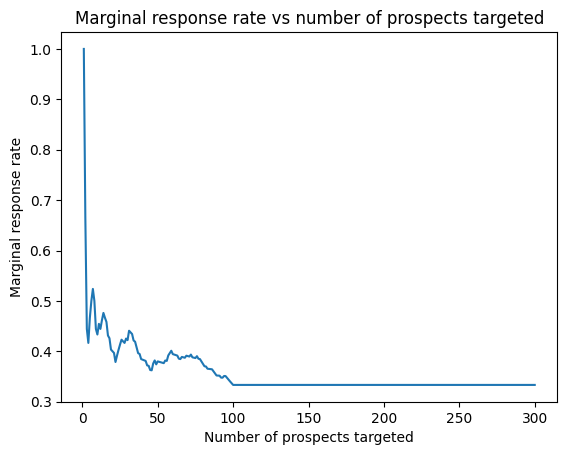

In [ ]:
# Calculate the cumulative number of prospects targeted
results['targeted'] = 1
results['cumulative_targeted'] = results['targeted'].cumsum()
print(results['cumulative_targeted'])
# Calculate the cumulative response rate at each percentile of the dataset
response_rates = []
for p in range(1, 301):
    k = int(len(results) * p / 100)
    targets = results.iloc[:k]
    response_rate = targets['y_actual'].sum() / targets['targeted'].sum()
    response_rates.append(response_rate)

# Plot the marginal response rate vs number of prospects targeted
plt.plot(results['cumulative_targeted'], response_rates)
plt.xlabel('Number of prospects targeted')
plt.ylabel('Marginal response rate')
plt.title('Marginal response rate vs number of prospects targeted')
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("ROC AUC score:", roc_auc)
confusion_matrix(y_test,y_pred)
pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True)

Accuracy: 0.66
Precision: 0.4
Recall: 0.04
F1 score: 0.07272727272727272
ROC AUC score: 0.505


Predicted,0,1,All
Actual,,,
0,194,6,200
1,96,4,100
All,290,10,300


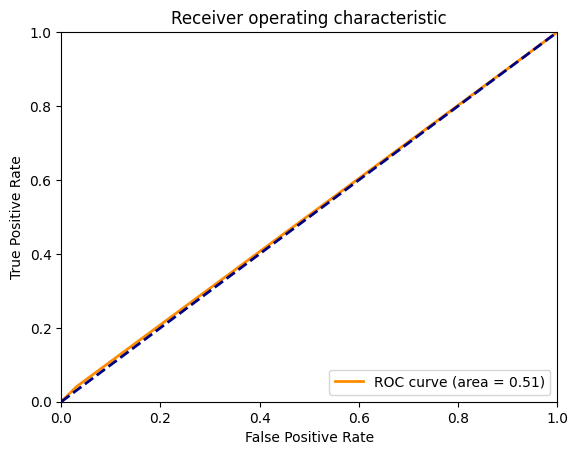

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the AUC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#
y_pred.sum()


10

In [ ]:
y_test.sum()

100

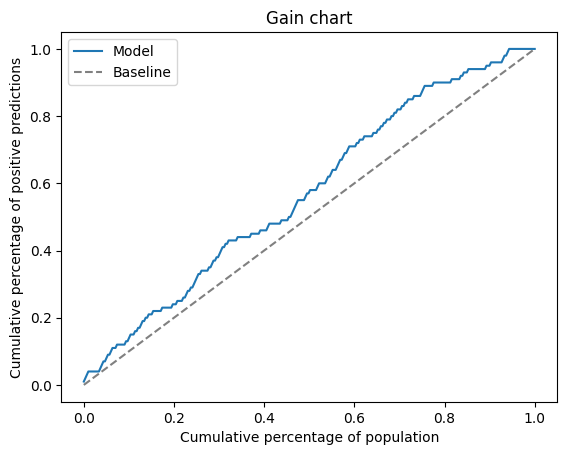

In [ ]:
df_gain = pd.DataFrame({'ActualAccept': y_test, 'Probability': y_prob})
df_gain = df_gain.sort_values(by='Probability', ascending=False)
df_gain['PositivePredictions'] = np.cumsum(df_gain['ActualAccept']) / df_gain['ActualAccept'].sum()

# Calculate the cumulative percentage of the population as you go down the ranked list of samples
df_gain['Population'] = np.linspace(0, 1, len(df_gain))

# Plot the gain chart
fig, ax = plt.subplots()

ax.plot(df_gain['Population'], df_gain['PositivePredictions'], label='Model')
ax.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Baseline')

ax.set_xlabel('Cumulative percentage of population')
ax.set_ylabel('Cumulative percentage of positive predictions')
ax.set_title('Gain chart')

ax.legend()
plt.show()

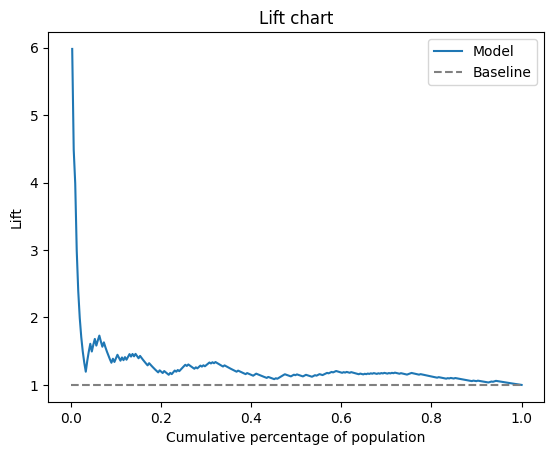

In [ ]:
# Calculate the lift values as the ratio of the percentage of positive predictions to the percentage of the population
df_gain['Lift'] = df_gain['PositivePredictions'] / df_gain['Population']

# Plot the lift chart
fig, ax = plt.subplots()

ax.plot(df_gain['Population'], df_gain['Lift'], label='Model')
ax.plot([0, 1], [1, 1], linestyle='--', color='grey', label='Baseline')

ax.set_xlabel('Cumulative percentage of population')
ax.set_ylabel('Lift')
ax.set_title('Lift chart')

ax.legend()
plt.show()

In [ ]:
model2 = xgb.XGBClassifier()
model2.fit(X_train, y_train)

# Predict the target variable for new data

y_pred = model2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("ROC AUC score:", roc_auc)

confusion_matrix(y_test,y_pred)
pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True)

Accuracy: 0.7166666666666667
Precision: 0.5652173913043478
Recall: 0.65
F1 score: 0.6046511627906976
ROC AUC score: 0.7


Predicted,0,1,All
Actual,,,
0,150,50,200
1,35,65,100
All,185,115,300


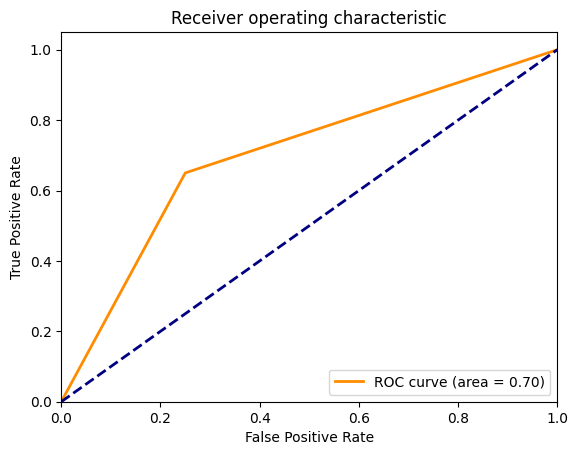

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the AUC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
y_test.sum()

100

In [ ]:
y_pred.sum()

115

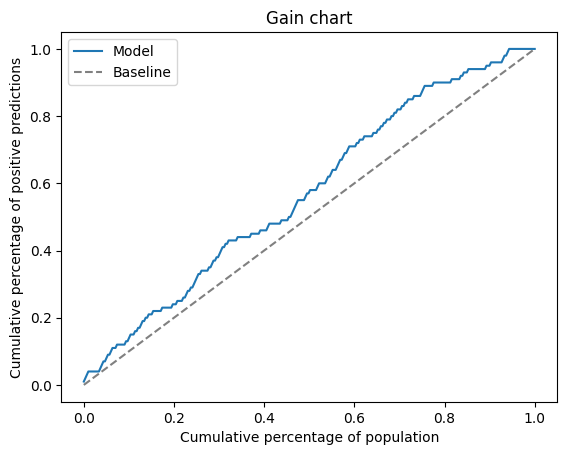

In [ ]:
df_gain = pd.DataFrame({'Accept': y_test, 'Probability': y_prob})
df_gain = df_gain.sort_values(by='Probability', ascending=False)
df_gain['PositivePredictions'] = np.cumsum(df_gain['Accept']) / df_gain['Accept'].sum()

# Calculate the cumulative percentage of the population as you go down the ranked list of samples
df_gain['Population'] = np.linspace(0, 1, len(df_gain))

# Plot the gain chart
fig, ax = plt.subplots()

ax.plot(df_gain['Population'], df_gain['PositivePredictions'], label='Model')
ax.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Baseline')

ax.set_xlabel('Cumulative percentage of population')
ax.set_ylabel('Cumulative percentage of positive predictions')
ax.set_title('Gain chart')

ax.legend()
plt.show()

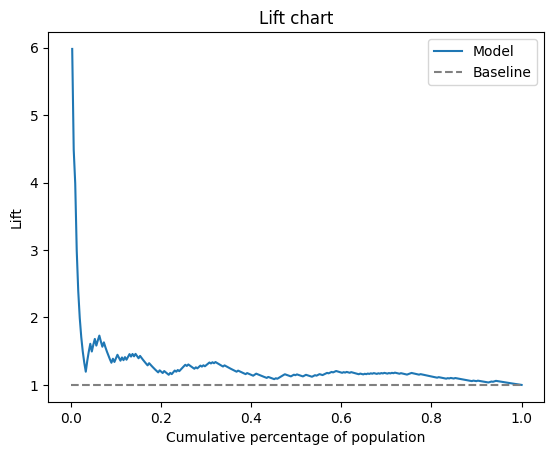

In [ ]:
# Calculate the lift values as the ratio of the percentage of positive predictions to the percentage of the population
df_gain['Lift'] = df_gain['PositivePredictions'] / df_gain['Population']

# Plot the lift chart
fig, ax = plt.subplots()

ax.plot(df_gain['Population'], df_gain['Lift'], label='Model')
ax.plot([0, 1], [1, 1], linestyle='--', color='grey', label='Baseline')

ax.set_xlabel('Cumulative percentage of population')
ax.set_ylabel('Lift')
ax.set_title('Lift chart')

ax.legend()
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model3 = KNeighborsClassifier(n_neighbors=5)
model3.fit(X_train, y_train)

# Predict the target variable for new data

y_pred = model3.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("ROC AUC score:", roc_auc)

confusion_matrix(y_test,y_pred)
pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True)

Accuracy: 0.5266666666666666
Precision: 0.375
Recall: 0.63
F1 score: 0.47014925373134336
ROC AUC score: 0.5525


Predicted,0,1,All
Actual,,,
0,95,105,200
1,37,63,100
All,132,168,300


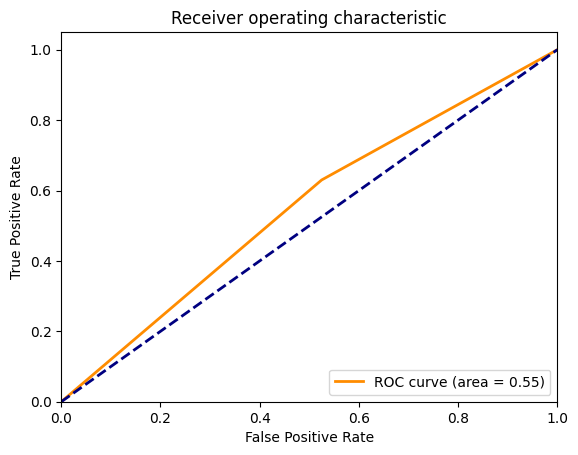

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the AUC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.svm import SVC
model4 = SVC(kernel='linear')

model4.fit(X_train, y_train)

# Predict the target variable for new data

y_pred = model4.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("ROC AUC score:", roc_auc)

confusion_matrix(y_test,y_pred)
pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True)

Accuracy: 0.6666666666666666
Precision: 0.5
Recall: 0.06
F1 score: 0.10714285714285712
ROC AUC score: 0.515


Predicted,0,1,All
Actual,,,
0,194,6,200
1,94,6,100
All,288,12,300


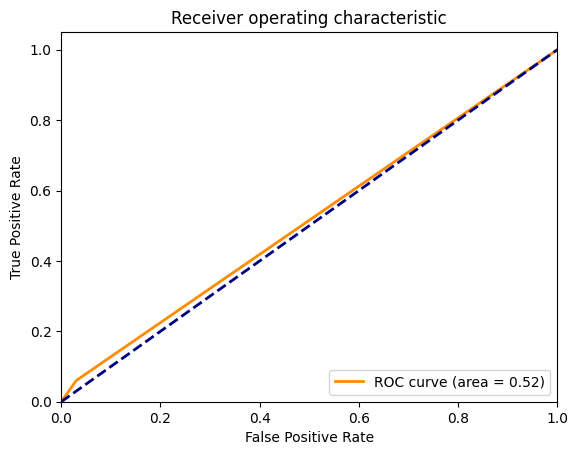

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the AUC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model5 = DecisionTreeClassifier()
model5.fit(X_train, y_train)

# Predict the target variable for new data

y_pred = model5.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("ROC AUC score:", roc_auc)

confusion_matrix(y_test,y_pred)
pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True)

Accuracy: 0.74
Precision: 0.5982142857142857
Recall: 0.67
F1 score: 0.6320754716981132
ROC AUC score: 0.7224999999999999


Predicted,0,1,All
Actual,,,
0,155,45,200
1,33,67,100
All,188,112,300


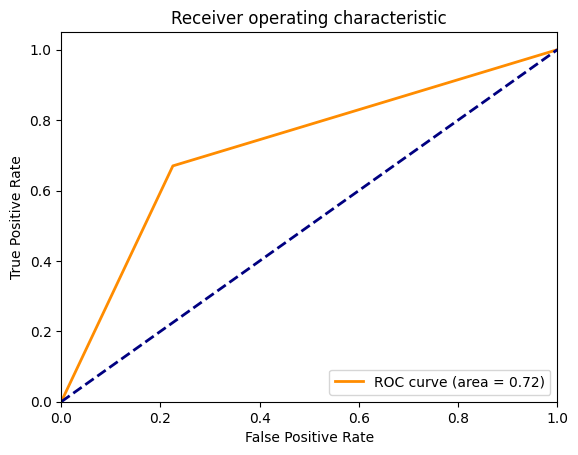

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the AUC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model6 = RandomForestClassifier(n_estimators=100)
model6.fit(X_train, y_train)
# Predict the target variable for new data

y_pred = model6.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("ROC AUC score:", roc_auc)

confusion_matrix(y_test,y_pred)
pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True)

Accuracy: 0.7066666666666667
Precision: 0.5697674418604651
Recall: 0.49
F1 score: 0.5268817204301076
ROC AUC score: 0.6524999999999999


Predicted,0,1,All
Actual,,,
0,163,37,200
1,51,49,100
All,214,86,300


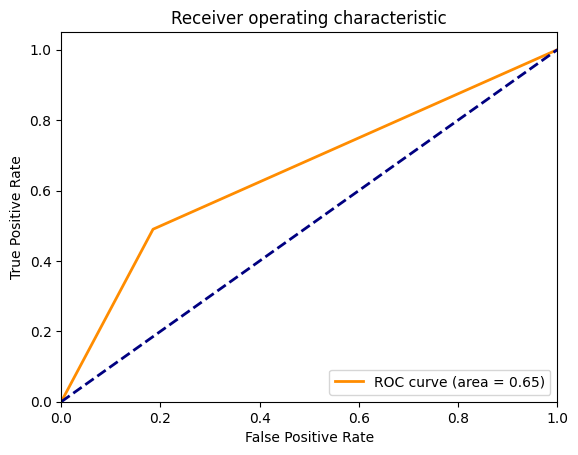

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the AUC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)

# Set the hyperparameters for the model
params = {
    "objective": "binary",
    "metric": "binary_logloss"
}

# Train the model on the training data
model7 = lgb.train(params, train_data, 100)

# Predict the target variable for the testing data
y_pred = model7.predict(X_test)
y_pred = [1 if pred >= 0.5 else 0 for pred in y_pred]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("ROC AUC score:", roc_auc)

[LightGBM] [Info] Number of positive: 72, number of negative: 128
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 156
[LightGBM] [Info] Number of data points in the train set: 200, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.360000 -> initscore=-0.575364
[LightGBM] [Info] Start training from score -0.575364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

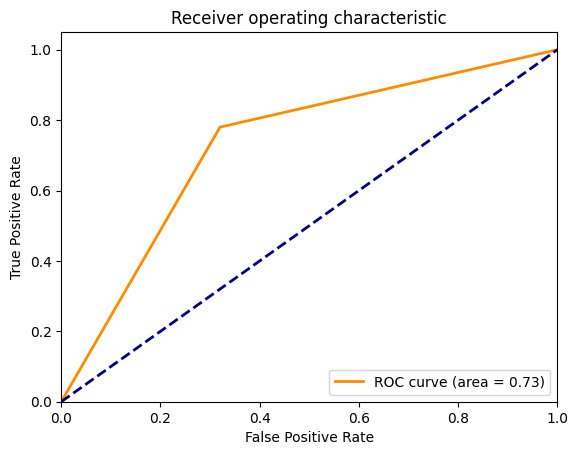

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the AUC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()